# llc4320 drifters spectra: Lagrangian vs Eulerian

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
from xhistogram.xarray import histogram
import xskillscore as xs
%matplotlib inline
from matplotlib import pyplot as plt
from cmocean import cm
import matplotlib.colors as colors
from matplotlib import gridspec

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.6303750.datarmor0/parcels-502027/libparcels_random_87c57219-1941-4f57-abe9-333fbacf8056.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=28, processes=14) # necessary?
    w = cluster.scale(jobs=1)
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.0.229:38579 Dashboard: http://10.148.0.229:8787/status,Cluster Workers: 14 Cores: 28 Memory: 111.72 GiB


______________
## lat*lon maps

In [4]:
E = '/home/datawork-lops-osi/equinox/mit4320/diags'
L = '/home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics'

In [5]:
E_Eulerian = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon_bands_from_2Dbin_spectra.zarr'))
E_Eulerian = (E_Eulerian.rename({'E_SSUV':'E_Eulerian'}))
E_Eulerian

,Array,Chunk
Bytes,4.89 MiB,10.55 kiB
Shape,"(15, 359, 119)","(1, 45, 30)"
Count,481 Tasks,480 Chunks
Type,float64,numpy.ndarray


In [6]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])
E_lagrangian = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands.zarr')
E_lagrangian = E_lagrangian.rename({'E':'E_Lagrangian'})
E_lagrangian = E_lagrangian.E_Lagrangian
E_lagrangian

<xarray.DataArray 'E_Lagrangian' (frequency_band: 15, lon_bins: 359, lat_bins: 119)>
dask.array<open_dataset-6419eef61746138f7a56ffae4aeafae2E, shape=(15, 359, 119), dtype=float64, chunksize=(1, 359, 119), chunktype=numpy.ndarray>
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5

In [7]:
# 2D binned Depth
V = ["SSUV"]
T = ["T60"]

sub = 1
dl = 1.
lon = np.arange(-180.,180., dl)
lat = np.arange(-60., 60., dl)
    
for v in V:
    for t in T:
        
        # read data
        ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_%s_%s.zarr'%(v,t)))
        ds = ds.isel(i=slice(0,None,sub),j=slice(0,None,sub))
        #ds = ds.where(ds.Depth>500, drop=False)
        #ds = ds.load()
        
        # lat, lon binning
        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
        N = histogram(
                      ds.lon.load(), ds.lat.load(), 
                      bins=[lon, lat], 
                      dim=['i', 'j', 'face'], 
                      block_size=None
                     )

        E = histogram(
                      ds.lon.load(), ds.lat.load(),
                      bins=[lon, lat], 
                      weights= ds.Depth.load(), 
                      dim=['i', 'j', 'face'], 
                      block_size=None
                     )
        
        # get binned results
        Depth_bin = (E/N).rename('E_depth').rename({'lon_bin': 'lon_bins','lat_bin': 'lat_bins'})        

In [8]:
ds_E = xr.merge([E_Eulerian,E_lagrangian,Depth_bin])
ds_E

<xarray.Dataset>
Dimensions:         (frequency_band: 15, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 45, 30), meta=np.ndarray>
    E_Lagrangian    (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 359, 119), meta=np.ndarray>
    E_depth         (lon_bins, lat_bins) float64 4.548e+03 ... 3.74e+03

# Figures

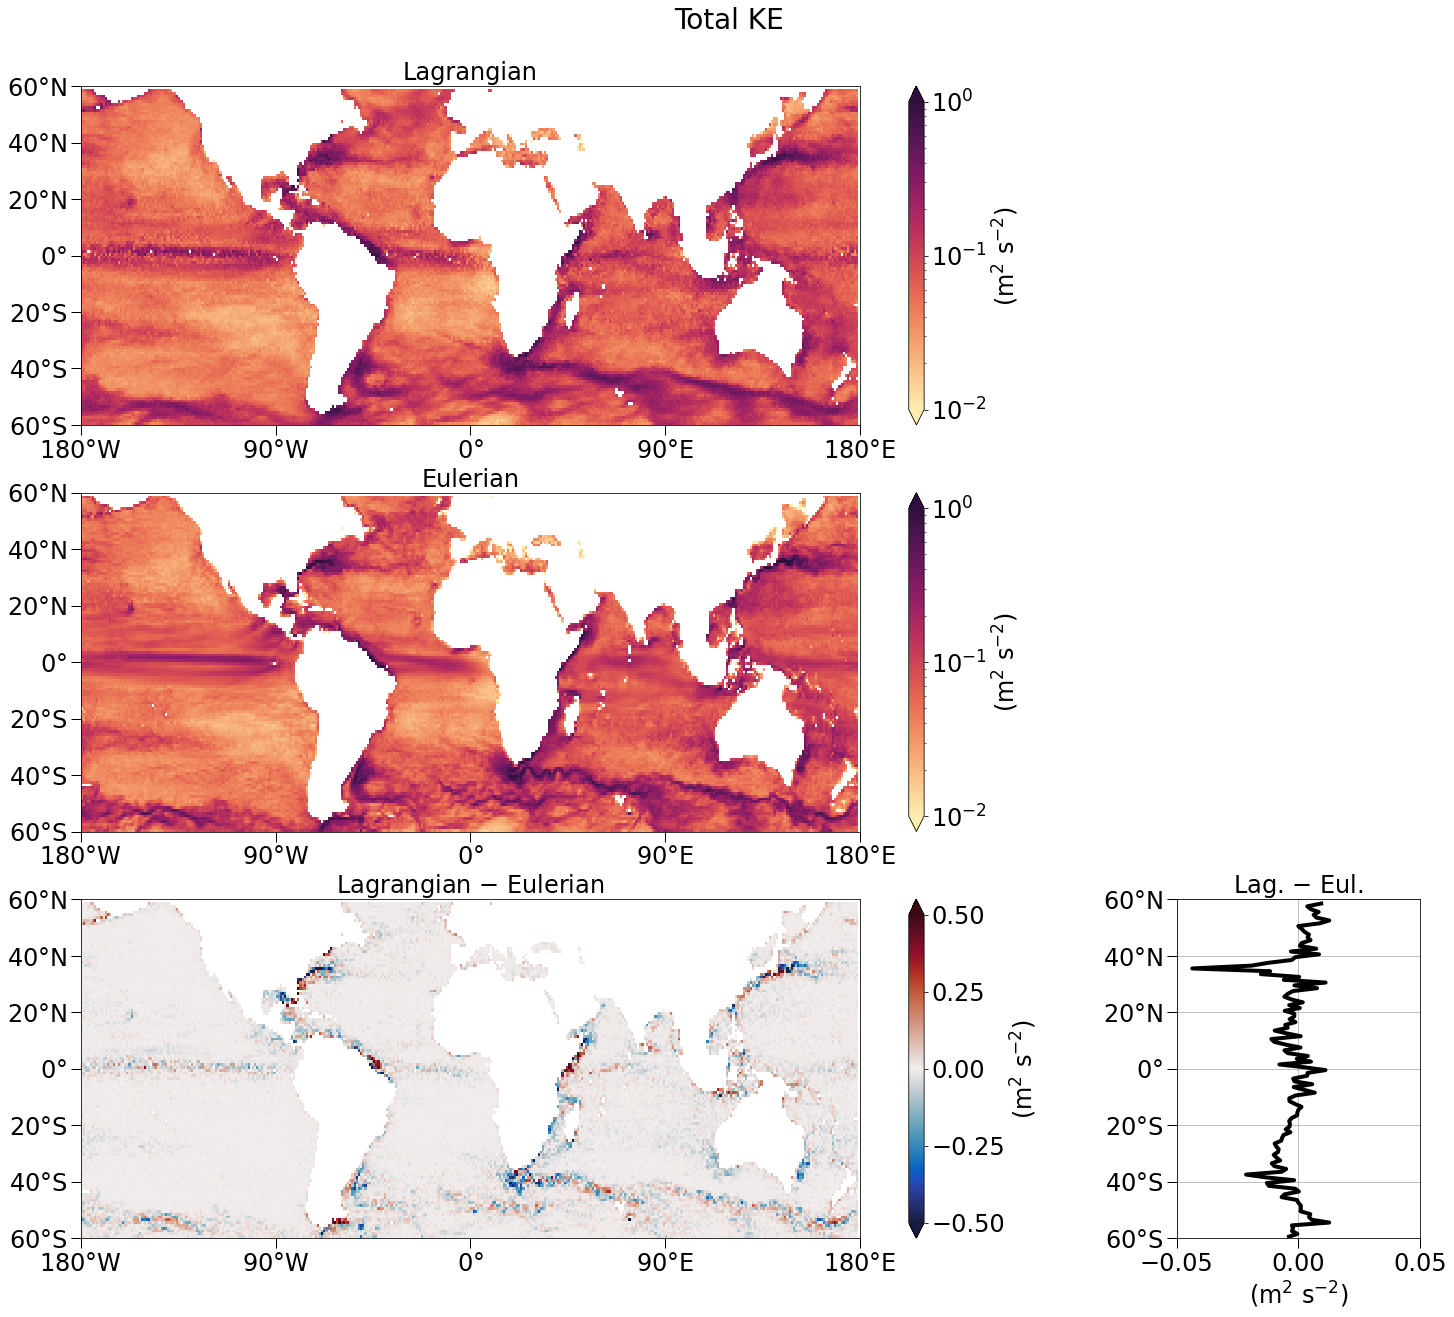

In [19]:
# Total KE
font_size = 24
plt.rc('font', size=24) 

fig, ax = plt.subplots(figsize=(24,20))
fig.subplots_adjust(top=0.925)

fig.suptitle("Total KE",fontsize=font_size+4, y=0.98)
gs = gridspec.GridSpec(3, 2, width_ratios=[4,1]) 

ax = plt.subplot(gs[0])
cax=(ds_E.E_Lagrangian.sel(frequency_band='total')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-2, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Lagrangian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(gs[2])
cax=(ds_E.E_Eulerian.sel(frequency_band='total')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-2, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(gs[4])
cax = (ds_E.E_Lagrangian.sel(frequency_band='total')-ds_E.E_Eulerian.sel(frequency_band='total')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, vmin=-0.5, vmax=0.5, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical', ticks=[-0.5, -0.25, 0, 0.25, 0.5])
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Lagrangian $-$ Eulerian' ,fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(gs[5])
(ds_E.E_Lagrangian.sel(frequency_band='total')-ds_E.E_Eulerian.sel(frequency_band='total')).mean('lon_bins').plot(y='lat_bins',linewidth=4,color='black')
ax.set_title('Lag. $-$ Eul.' ,fontsize=font_size)
ax.set_xlim(-0.05, 0.05)
ax.set_xticks([-0.05,  0., 0.05])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.grid()
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Global_map_total_KE.png')

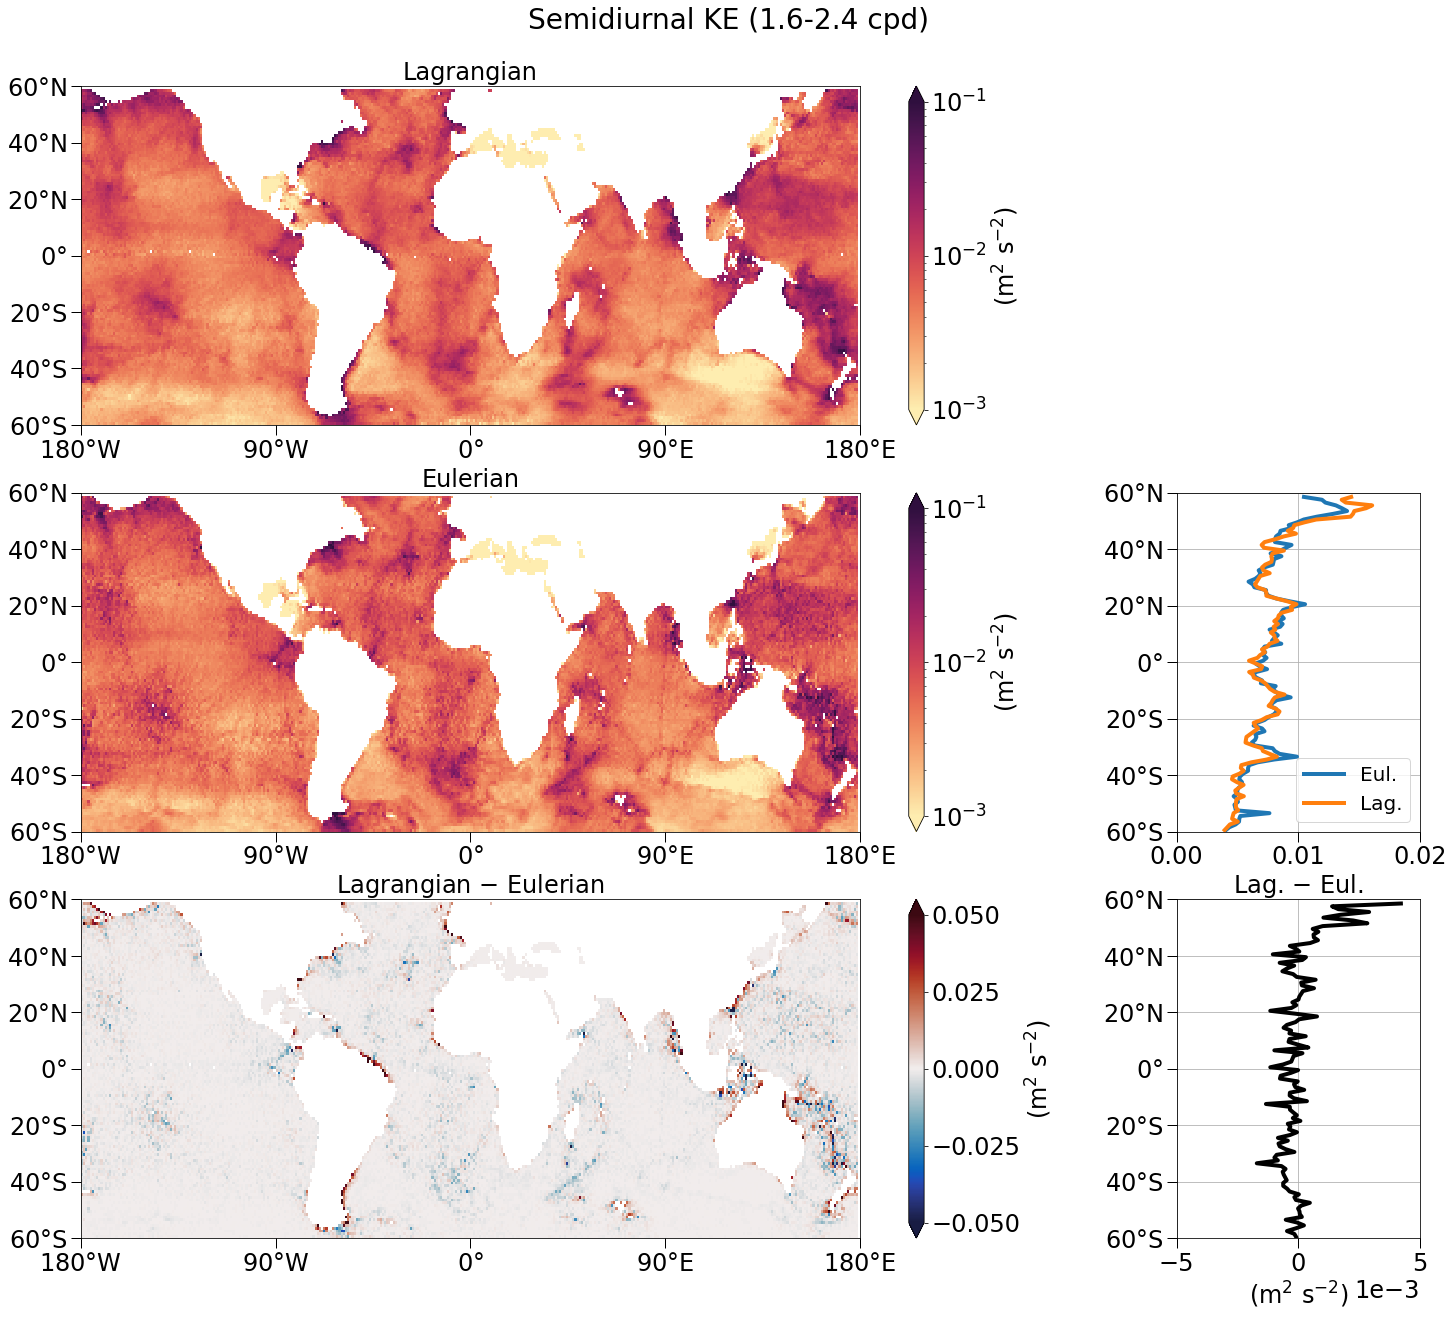

In [20]:
# semidiurnal
upper_limit = 0.1
plt.rc('font', size=24) 

font_size = 24
band = 'semidiurnal_0dot4'
fig, ax = plt.subplots(figsize=(24,20))
fig.subplots_adjust(top=0.925)

fig.suptitle("Semidiurnal KE (1.6-2.4 cpd)",fontsize=font_size+4, y=0.98)
gs = gridspec.GridSpec(3, 2, width_ratios=[4,1]) 

ax = plt.subplot(gs[0])
cax=(ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Lagrangian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(gs[2])
cax=(ds_E.E_Eulerian.sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

labels = ['Eul.', 'Lag.']
ax = plt.subplot(gs[3])
ds_E.E_Eulerian.sel(frequency_band=band).mean('lon_bins').plot(y='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band=band).mean('lon_bins').plot(y='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.legend(prop={'size': font_size-4},frameon=True); ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.01,0.02])
ax.tick_params(direction='out', length=10, width=1)
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)


ax = plt.subplot(gs[4])
cax = (ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band=band)-ds_E.E_Eulerian.sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, vmin=-0.05, vmax=0.05, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical', ticks=[-0.05, -0.025, 0, 0.025, 0.05])
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Lagrangian $-$ Eulerian',fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

labels = ['Eul.', 'Lag.']
ax = plt.subplot(gs[5])
(ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band=band)-ds_E.E_Eulerian.sel(frequency_band=band)).mean('lon_bins').plot(y='lat_bins',linewidth=4,color='black')
ax.set_title('Lag. $-$ Eul.',fontsize=font_size)
ax.set_xlim(-0.005, 0.005)
ax.set_yticks([-0.005, -0.0025, 0, 0.0025, 0.005])
ax.set_yticklabels(['-0.005','','0','','0.005'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.grid()
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
plt.ticklabel_format(axis='x',style='sci', scilimits=(0,0))

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Global_map_semidiurnal_KE_together.png')

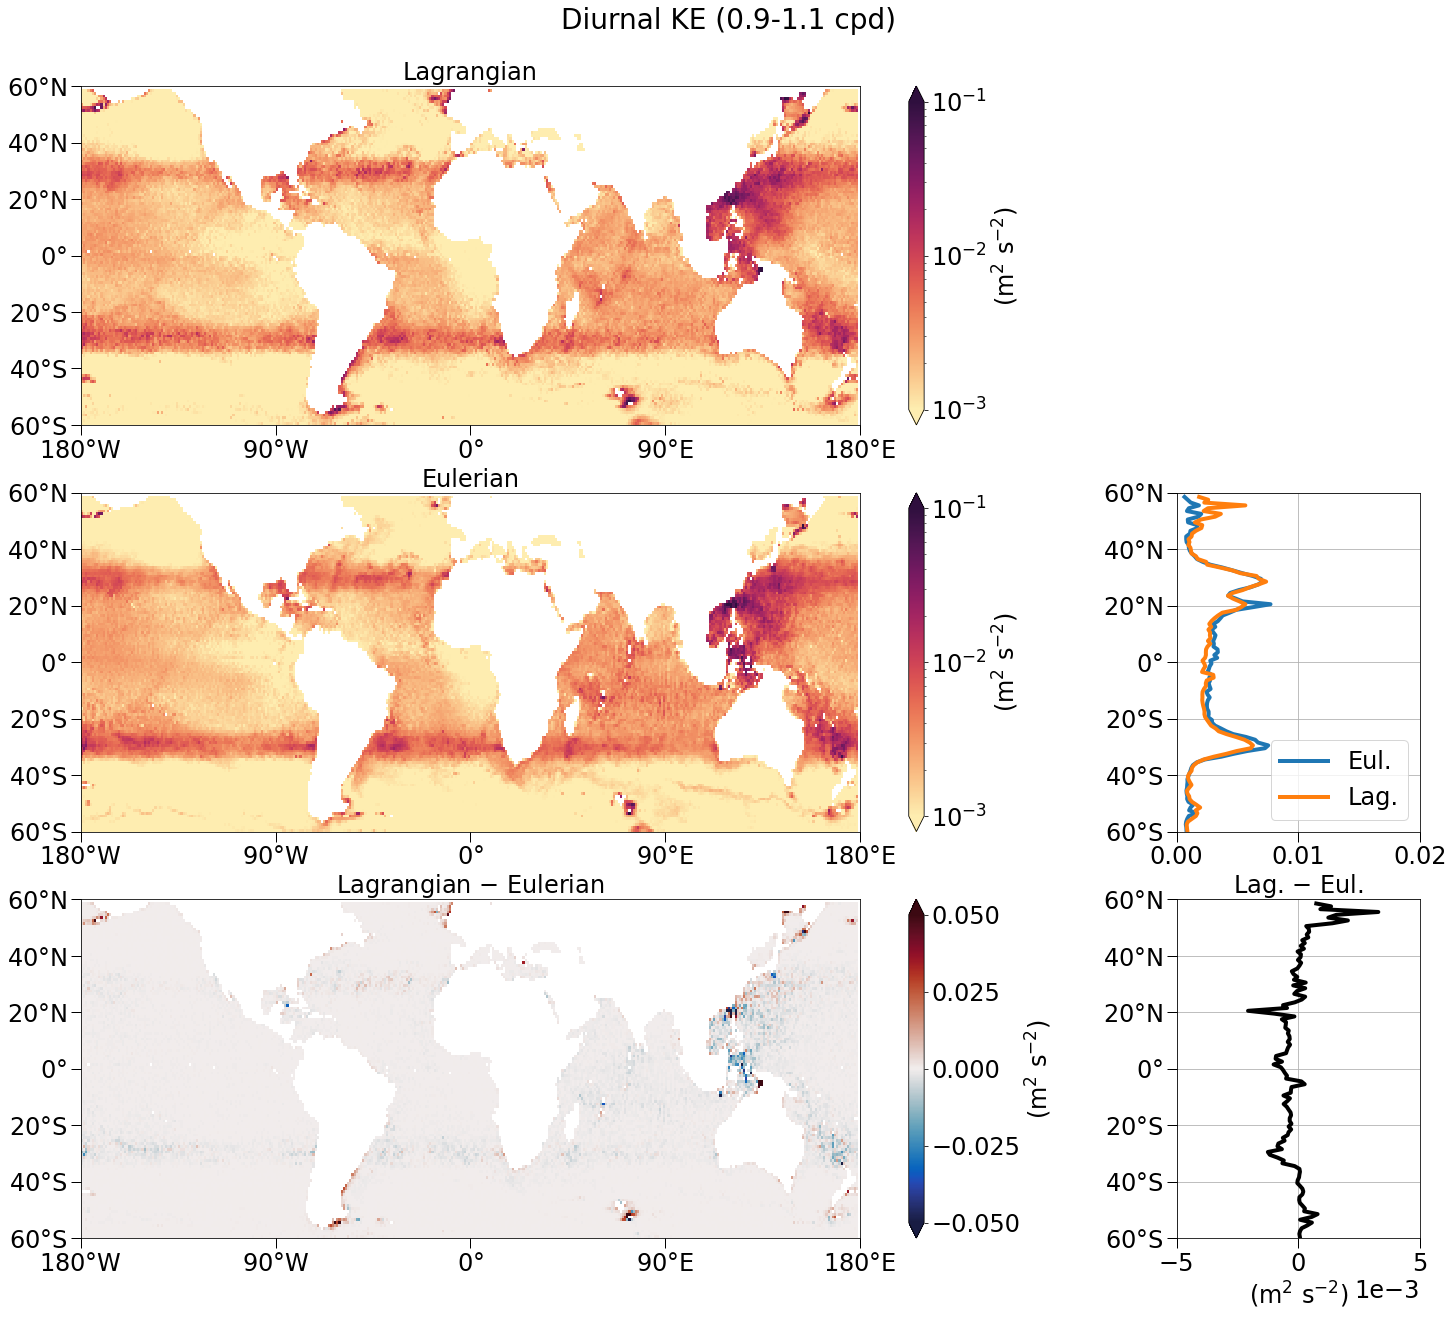

In [9]:
# diurnal
upper_limit = 0.2
plt.rc('font', size=24) 

font_size = 24
band = 'diurnal_0dot1'
fig, ax = plt.subplots(figsize=(24,20))
fig.subplots_adjust(top=0.925)

fig.suptitle("Diurnal KE (0.9-1.1 cpd)",fontsize=font_size+4, y=0.98)
gs = gridspec.GridSpec(3, 2, width_ratios=[4,1]) 

ax = plt.subplot(gs[0])
cax=(ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Lagrangian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(gs[2])
cax=(ds_E.E_Eulerian.sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

labels = ['Eul.', 'Lag.']
ax = plt.subplot(gs[3])
ds_E.E_Eulerian.sel(frequency_band=band).mean('lon_bins').plot(y='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band=band).mean('lon_bins').plot(y='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.legend(prop={'size': font_size-4},frameon=True); ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.02])
ax.tick_params(direction='out', length=10, width=1)
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.legend(loc='lower right', prop={'size': font_size})


ax = plt.subplot(gs[4])
cax = (ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band=band)-ds_E.E_Eulerian.sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, vmin=-0.05, vmax=0.05, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical', ticks=[-0.05, -0.025, 0, 0.025, 0.05])
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Lagrangian $-$ Eulerian',fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(gs[5])
(ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band=band)-ds_E.E_Eulerian.sel(frequency_band=band)).mean('lon_bins').plot(y='lat_bins',linewidth=4,color='black')
ax.set_title('Lag. $-$ Eul.',fontsize=font_size)
ax.set_xlim(-0.005, 0.005)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.grid()
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
plt.ticklabel_format(axis='x',style='sci', scilimits=(0,0))

#plt.tight_layout()

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Global_map_diurnal_KE_together.png')

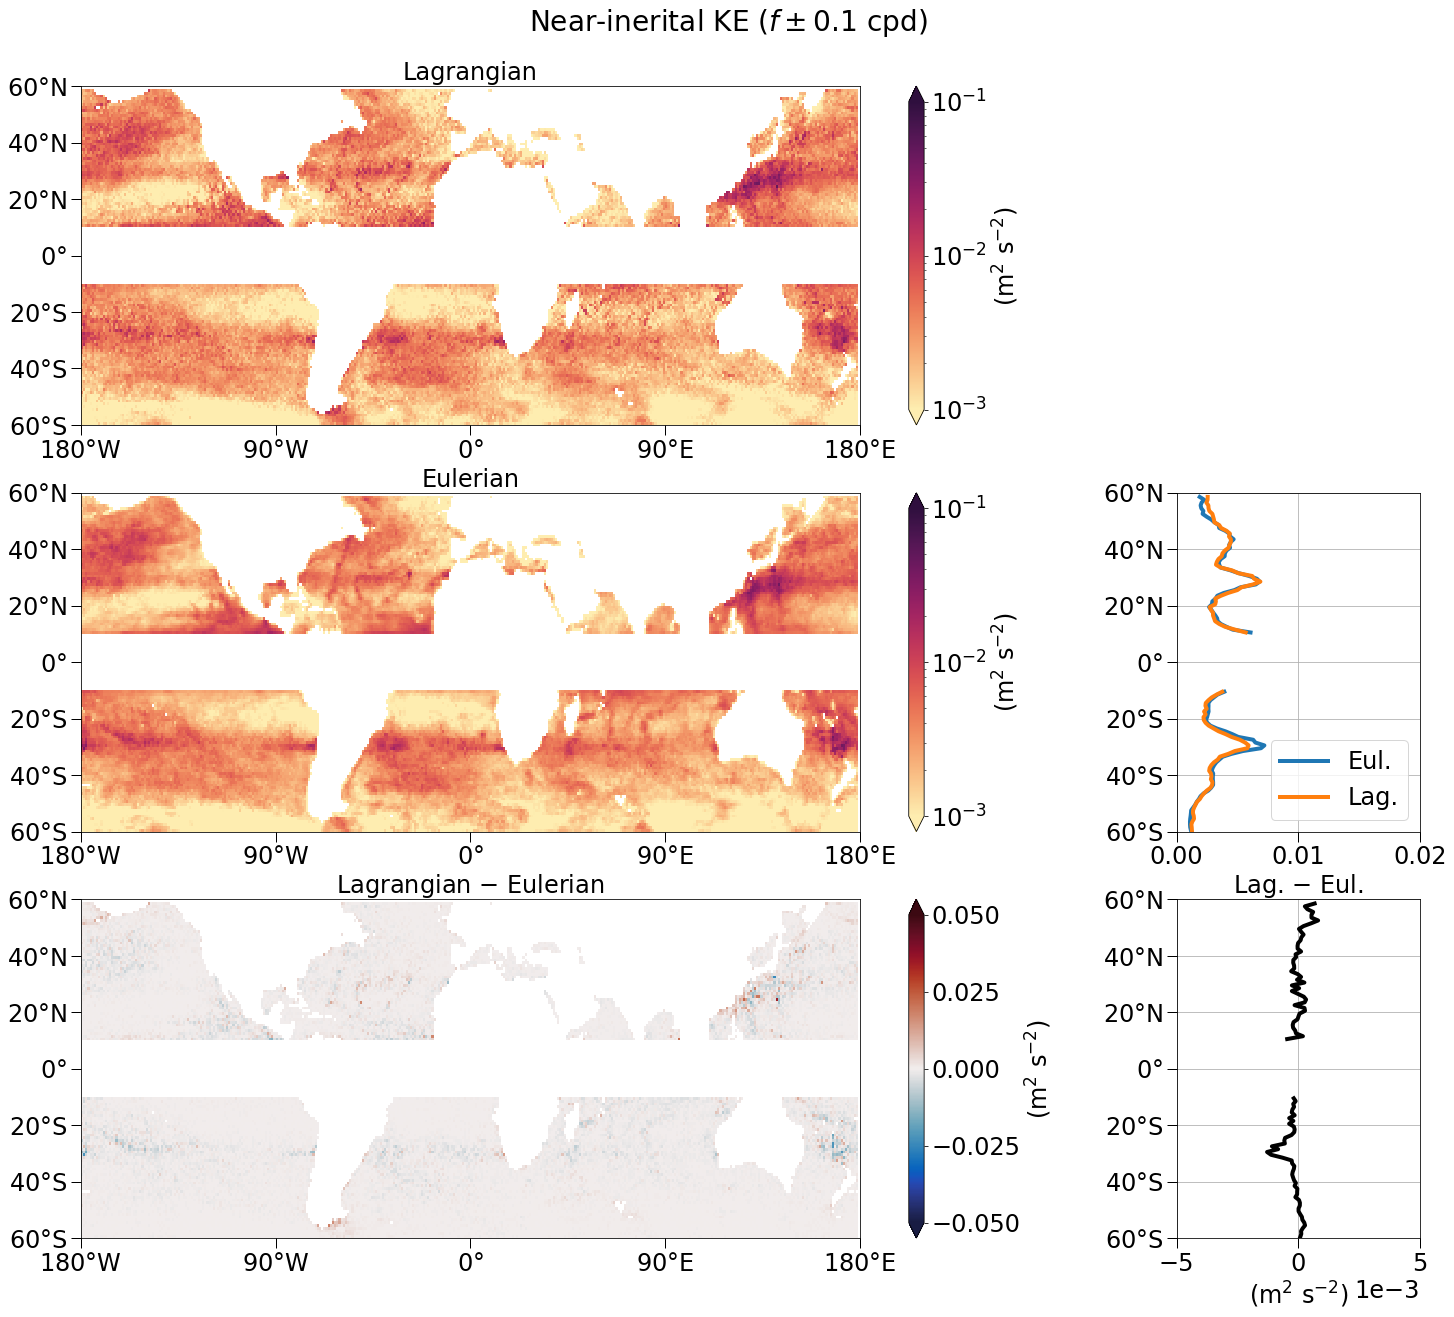

In [10]:
# near-inertial
upper_limit = 0.2
lat_mask = 10
plt.rc('font', size=24) 

font_size = 24
band = 'inertial_0dot1'
fig, ax = plt.subplots(figsize=(24,20))
fig.subplots_adjust(top=0.925)
fig.suptitle("Near-inerital KE ($f\pm$0.1 cpd)",fontsize=font_size+4, y=0.98)
gs = gridspec.GridSpec(3, 2, width_ratios=[4,1]) 

ax = plt.subplot(gs[0])
cax=(ds_E.E_Lagrangian.where(np.abs(ds_E.lat_bins)>lat_mask).sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Lagrangian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(gs[2])
cax=(ds_E.E_Eulerian.where(np.abs(ds_E.lat_bins)>lat_mask).sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

labels = ['Eul.', 'Lag.']
ax = plt.subplot(gs[3])
ds_E.E_Eulerian.where(np.abs(ds_E.lat_bins)>lat_mask).sel(frequency_band=band).mean('lon_bins').plot(y='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
ds_E.E_Lagrangian.where(np.abs(ds_E.lat_bins)>lat_mask).sel(frequency_band=band).mean('lon_bins').plot(y='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.legend(prop={'size': font_size-4},frameon=True); ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.02])
ax.tick_params(direction='out', length=10, width=1)
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.legend(loc='lower right', prop={'size': font_size})


ax = plt.subplot(gs[4])
cax = (ds_E.E_Lagrangian.where(np.abs(ds_E.lat_bins)>lat_mask).sel(frequency_band=band)-ds_E.where(np.abs(ds_E.lat_bins)>lat_mask).E_Eulerian.sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, vmin=-0.05, vmax=0.05, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical', ticks=[-0.05, -0.025, 0, 0.025, 0.05])
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Lagrangian $-$ Eulerian',fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(gs[5])
(ds_E.E_Lagrangian.where(np.abs(ds_E.lat_bins)>lat_mask).sel(frequency_band=band)-ds_E.E_Eulerian.where(np.abs(ds_E.lat_bins)>lat_mask).sel(frequency_band=band)).mean('lon_bins').plot(y='lat_bins',linewidth=4,color='black')
ax.set_title('Lag. $-$ Eul.',fontsize=font_size)
ax.set_xlim(-0.005, 0.005)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.grid()
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
plt.ticklabel_format(axis='x',style='sci', scilimits=(0,0))

#plt.tight_layout()

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Global_map_near_inertial_KE_together.png')

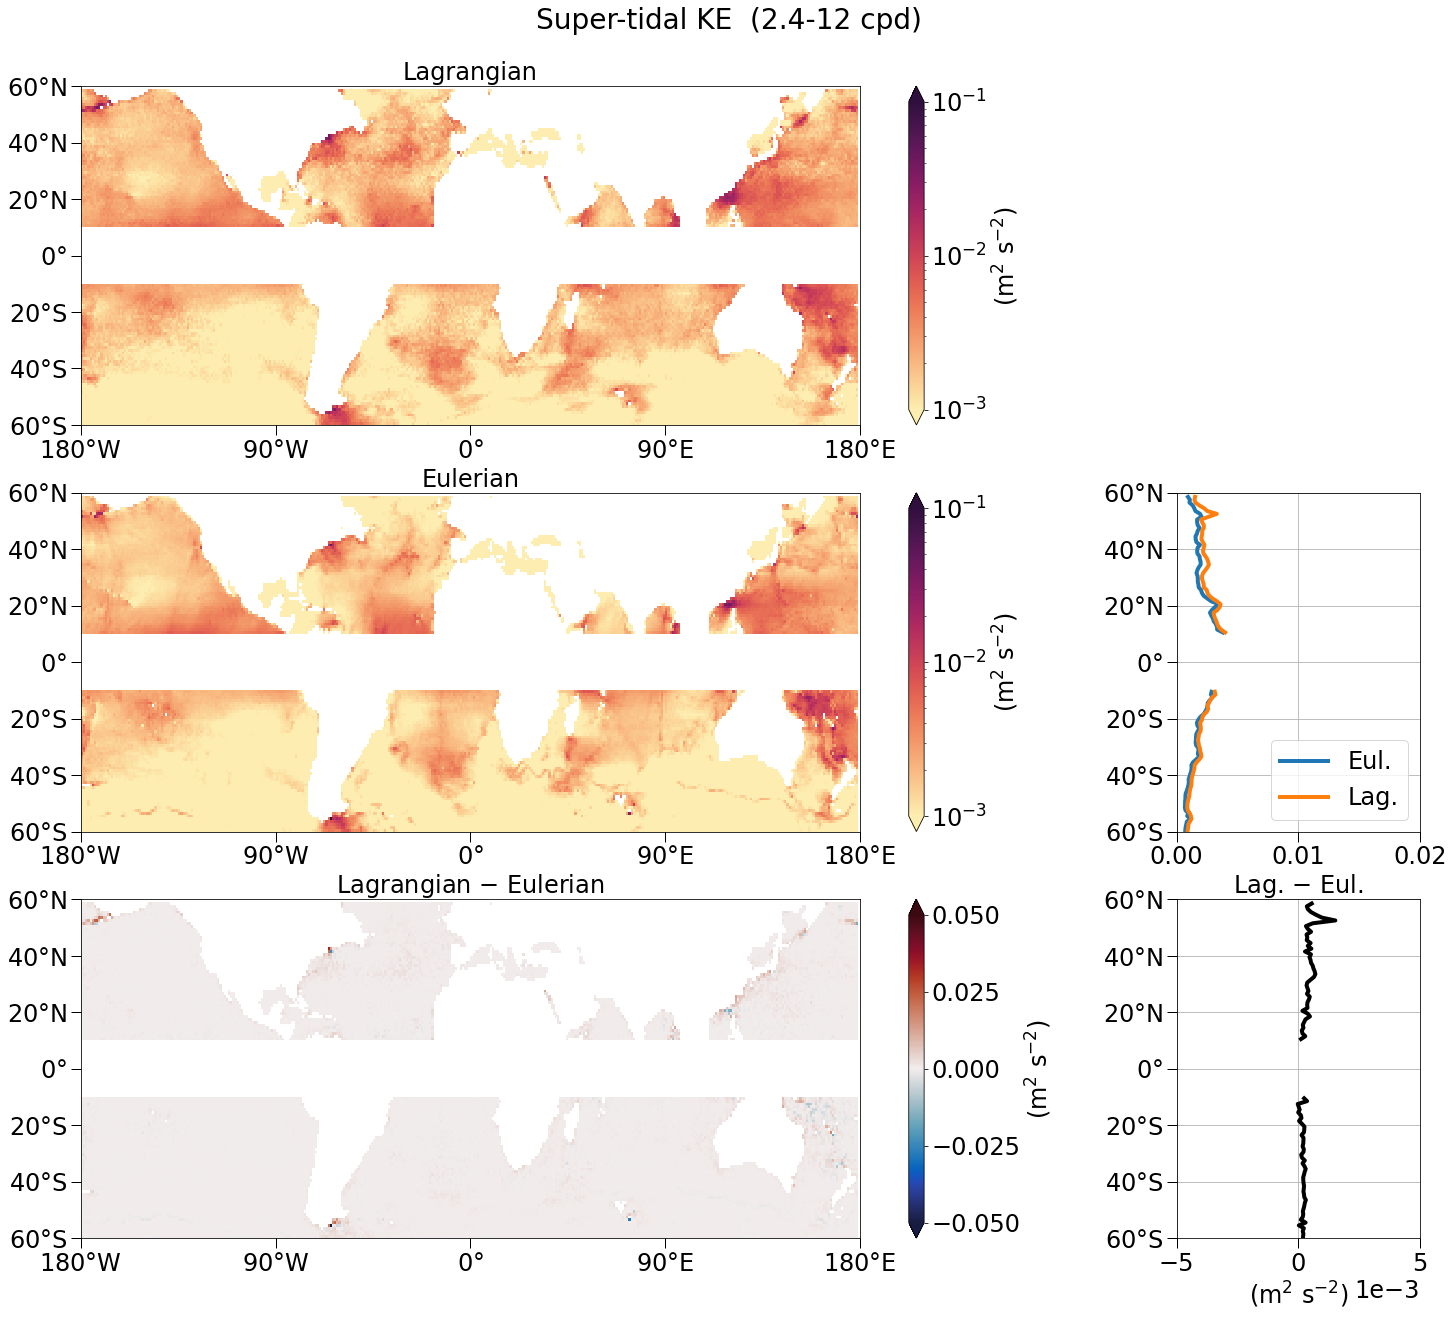

In [11]:
# super-tidal
upper_limit = 0.2
lat_mask = 10
plt.rc('font', size=24) 

font_size = 24
band = 'supertidal'
fig, ax = plt.subplots(figsize=(24,20))
fig.subplots_adjust(top=0.925)
fig.suptitle("Super-tidal KE  (2.4-12 cpd)",fontsize=font_size+4, y=0.98)
gs = gridspec.GridSpec(3, 2, width_ratios=[4,1]) 

ax = plt.subplot(gs[0])
cax=(ds_E.E_Lagrangian.where(np.abs(ds_E.lat_bins)>lat_mask).sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Lagrangian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(gs[2])
cax=(ds_E.E_Eulerian.where(np.abs(ds_E.lat_bins)>lat_mask).sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

labels = ['Eul.', 'Lag.']
ax = plt.subplot(gs[3])
ds_E.E_Eulerian.where(np.abs(ds_E.lat_bins)>lat_mask).sel(frequency_band=band).mean('lon_bins').plot(y='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
ds_E.E_Lagrangian.where(np.abs(ds_E.lat_bins)>lat_mask).sel(frequency_band=band).mean('lon_bins').plot(y='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.legend(prop={'size': font_size-4},frameon=True); ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.02])
ax.tick_params(direction='out', length=10, width=1)
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.legend(loc='lower right', prop={'size': font_size})


ax = plt.subplot(gs[4])
cax = (ds_E.E_Lagrangian.where(np.abs(ds_E.lat_bins)>lat_mask).sel(frequency_band=band)-ds_E.where(np.abs(ds_E.lat_bins)>lat_mask).E_Eulerian.sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, vmin=-0.05, vmax=0.05, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical', ticks=[-0.05, -0.025, 0, 0.025, 0.05])
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Lagrangian $-$ Eulerian',fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(gs[5])
(ds_E.E_Lagrangian.where(np.abs(ds_E.lat_bins)>lat_mask).sel(frequency_band=band)-ds_E.E_Eulerian.where(np.abs(ds_E.lat_bins)>lat_mask).sel(frequency_band=band)).mean('lon_bins').plot(y='lat_bins',linewidth=4,color='black')
ax.set_title('Lag. $-$ Eul.',fontsize=font_size)
ax.set_xlim(-0.005, 0.005)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.grid()
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
plt.ticklabel_format(axis='x',style='sci', scilimits=(0,0))

#plt.tight_layout()

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Global_map_super_tidal_KE_together.png')

_________
## 2D Histogram

### Semi-diurnal tides

In [13]:
x_bins = np.arange(0, 0.025, 0.001)
y_bins = np.arange(0, 0.025, 0.001)

SD_01cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1'),
                     ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1'),
                     bins=[x_bins, y_bins],
                     block_size=None)

SD_02cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot2'),
                     ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot2'),
                     bins=[x_bins, y_bins],
                     block_size=None)

SD_03cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot3'),
                     ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot3'),
                     bins=[x_bins, y_bins],
                     block_size=None)

SD_04cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot4'),
                     ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4'),
                     bins=[x_bins, y_bins],
                     block_size=None)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


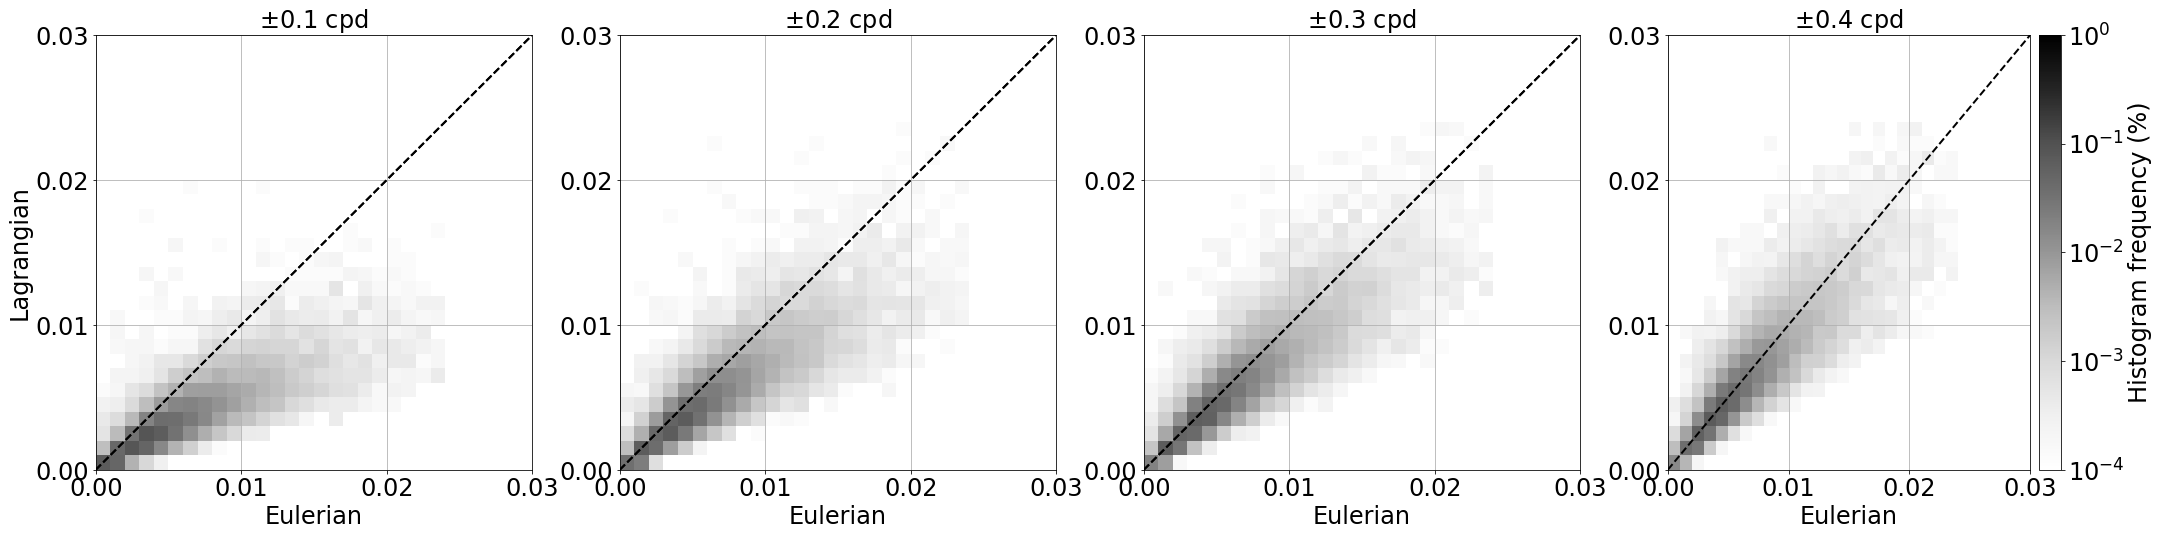

In [32]:
# Histogram for lat*lon KE
plt.rc('font', size=24) 
font_size = 24
vmin = -4
vmax = 0
cmap = 'Greys'
color = "black"
lims = (0, .03)


fig = plt.figure(figsize=(36,8))
ax = plt.subplot(141)
cax = np.log10(SD_01cpd/SD_01cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('Lagrangian',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.1 cpd',fontsize=font_size)

ax = plt.subplot(142)
cax = np.log10(SD_02cpd/SD_02cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.2 cpd',fontsize=font_size)

ax = plt.subplot(143)
cax = np.log10(SD_03cpd/SD_03cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.3 cpd',fontsize=font_size)

ax = plt.subplot(144)
cax = np.log10(SD_04cpd/SD_04cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[-4, -3, -2, -1, 0], pad=0.02)
cbar.set_ticklabels(['10$^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$','10$^{0}$'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Histogram frequency (%)', fontsize=font_size)
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.4 cpd',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/KE_2D_histogram_SD.png')

### Diurnal tides

In [33]:
x_bins = np.arange(0, 0.025, 0.001)
y_bins = np.arange(0, 0.025, 0.001)

D_01cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot1'),
                     ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot1'),
                     bins=[x_bins, y_bins],
                     block_size=None)

D_02cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot2'),
                     ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot2'),
                     bins=[x_bins, y_bins],
                     block_size=None)

D_03cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot3'),
                     ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot3'),
                     bins=[x_bins, y_bins],
                     block_size=None)

D_04cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot4'),
                     ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot4'),
                     bins=[x_bins, y_bins],
                     block_size=None)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


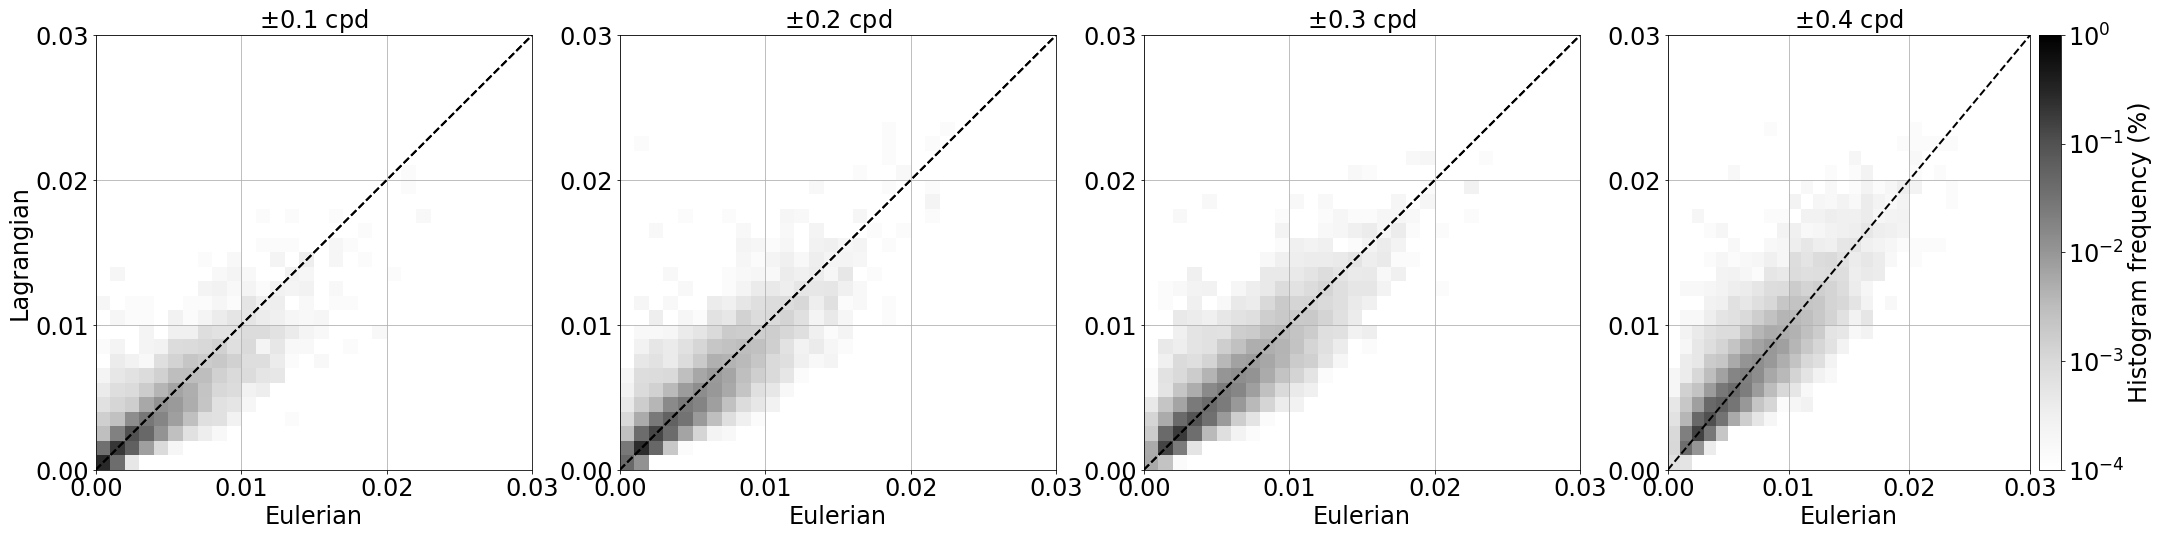

In [34]:
# Histogram for lat*lon KE
plt.rc('font', size=24) 
font_size = 24
vmin = -4
vmax = 0
cmap = 'Greys'
color = "black"
lims = (0, .03)

fig = plt.figure(figsize=(36,8))
ax = plt.subplot(141)
cax = np.log10(D_01cpd/SD_01cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('Lagrangian',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.1 cpd',fontsize=font_size)

ax = plt.subplot(142)
cax = np.log10(D_02cpd/SD_02cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.2 cpd',fontsize=font_size)

ax = plt.subplot(143)
cax = np.log10(D_03cpd/SD_03cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.3 cpd',fontsize=font_size)

ax = plt.subplot(144)
cax = np.log10(D_04cpd/SD_04cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[-4, -3, -2, -1, 0], pad=0.02)
cbar.set_ticklabels(['10$^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$','10$^{0}$'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Histogram frequency (%)', fontsize=font_size)
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.4 cpd',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/KE_2D_histogram_D.png')

### Near-inertial waves

In [ ]:
x_bins = np.arange(0, 0.025, 0.001)
y_bins = np.arange(0, 0.025, 0.001)

NI_01cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='inertial_0dot1').where(np.abs(ds_E.lat_bins)>15),
                     ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot1').where(np.abs(ds_E.lat_bins)>15),
                     bins=[x_bins, y_bins],
                     block_size=None)

NI_02cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='inertial_0dot2').where(np.abs(ds_E.lat_bins)>15),
                     ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot2').where(np.abs(ds_E.lat_bins)>15),
                     bins=[x_bins, y_bins],
                     block_size=None)

NI_03cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='inertial_0dot3').where(np.abs(ds_E.lat_bins)>15),
                     ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot3').where(np.abs(ds_E.lat_bins)>15),
                     bins=[x_bins, y_bins],
                     block_size=None)

NI_04cpd = histogram(ds_E.E_Eulerian.sel(frequency_band='inertial_0dot4').where(np.abs(ds_E.lat_bins)>15),
                     ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot4').where(np.abs(ds_E.lat_bins)>15),
                     bins=[x_bins, y_bins],
                     block_size=None)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


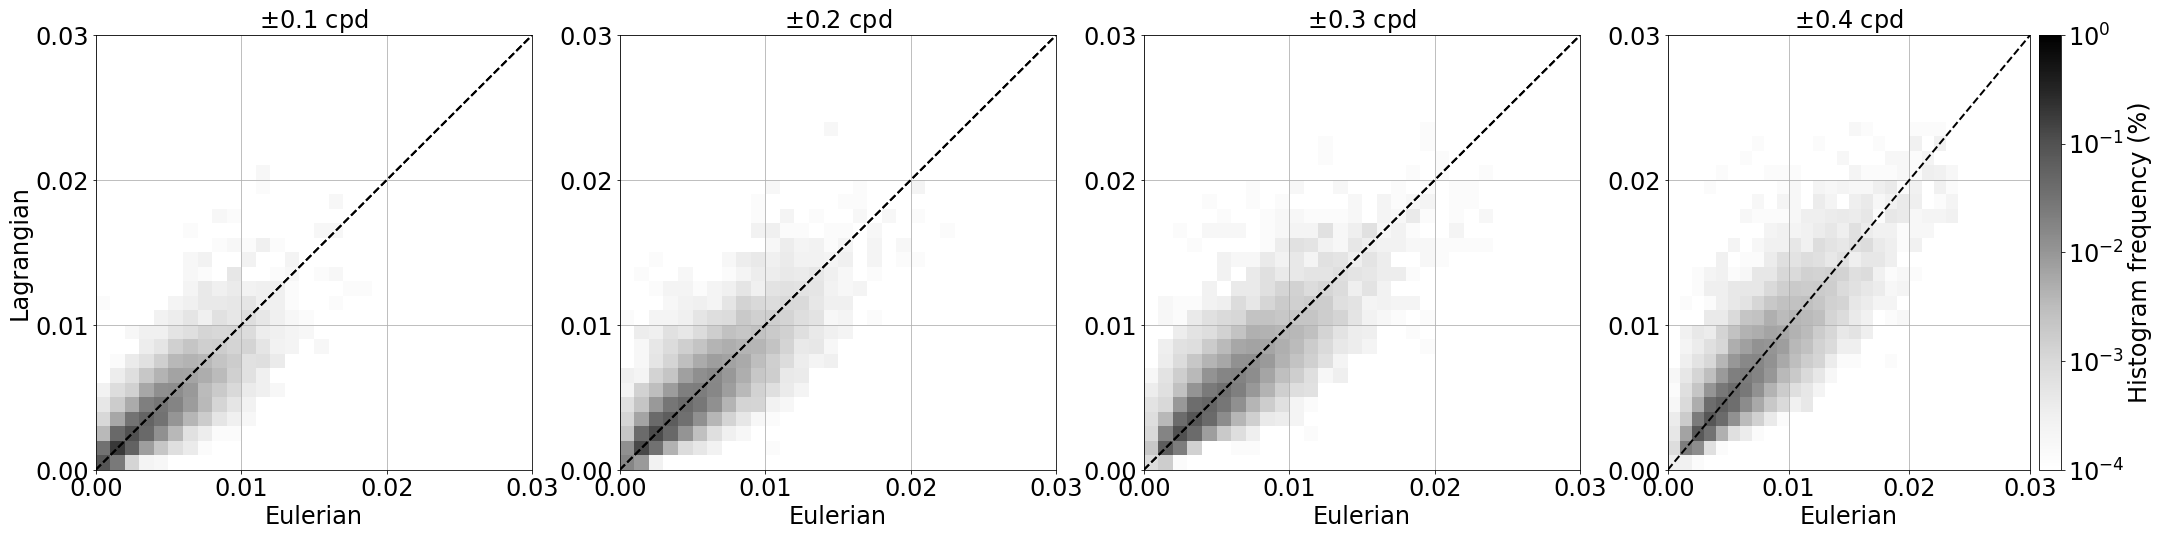

In [36]:
# Histogram for lat*lon KE
plt.rc('font', size=24) 
font_size = 24
vmin = -4
vmax = 0
cmap = 'Greys'
color = "black"
lims = (0, .03)

fig = plt.figure(figsize=(36,8))
ax = plt.subplot(141)
cax = np.log10(NI_01cpd/NI_01cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('Lagrangian',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.1 cpd',fontsize=font_size)

ax = plt.subplot(142)
cax = np.log10(NI_02cpd/NI_02cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.2 cpd',fontsize=font_size)

ax = plt.subplot(143)
cax = np.log10(NI_03cpd/NI_03cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.3 cpd',fontsize=font_size)

ax = plt.subplot(144)
cax = np.log10(NI_04cpd/NI_04cpd.sum()).plot(x='E_Eulerian_bin',y='E_Lagrangian_bin',cmap=cmap,vmin=vmin,vmax=vmax, add_colorbar = False) 
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[-4, -3, -2, -1, 0], pad=0.02)
cbar.set_ticklabels(['10$^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$','10$^{0}$'])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Histogram frequency (%)', fontsize=font_size)
ax.grid()
ax.plot(lims, lims, color=color, ls="--", linewidth=2)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xticks([0, 0.01,0.02,0.03])
ax.set_yticks([0, 0.01,0.02,0.03])
ax.set_title('$\pm$0.4 cpd',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/KE_2D_histogram_NI.png')

____________
# Statistics

In [9]:
ds_E.load()

<xarray.Dataset>
Dimensions:         (frequency_band: 15, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 0.1136 ... 0...
    E_Lagrangian    (frequency_band, lon_bins, lat_bins) float64 0.09624 ... ...
    E_depth         (lon_bins, lat_bins) float64 4.548e+03 ... 3.74e+03

In [10]:
ds_E.frequency_band

<xarray.DataArray 'frequency_band' (frequency_band: 15)>
array(['total', 'low', 'supertidal', 'diurnal_0dot1', 'diurnal_0dot2',
       'diurnal_0dot3', 'diurnal_0dot4', 'semidiurnal_0dot1',
       'semidiurnal_0dot2', 'semidiurnal_0dot3', 'semidiurnal_0dot4',
       'inertial_0dot1', 'inertial_0dot2', 'inertial_0dot3', 'inertial_0dot4'],
      dtype=object)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'

## Correlation Coefficient

In [18]:
# all
R = xr.corr(ds_E.E_Eulerian,
            ds_E.E_Lagrangian,
            dim=['lat_bins','lon_bins']
           )
R.values

array([0.82305868, 0.82850987, 0.71205043, 0.7535519 , 0.76845071,
       0.77031097, 0.35707227, 0.42035523, 0.45365219, 0.47283877,
       0.83777441, 0.83754816, 0.83832456, 0.82403011])

In [26]:
# exclude values >0.2
upper_limit= 0.2
R = xr.corr(ds_E.E_Eulerian.where(ds_E.E_Eulerian<upper_limit),
            ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit),
            dim=['lat_bins','lon_bins']
           )
R.values

array([0.84659644, 0.85070186, 0.71639479, 0.75785577, 0.77233642,
       0.774018  , 0.50222586, 0.58332799, 0.64119098, 0.66201533,
       0.92304208, 0.92799975, 0.92109026, 0.91883276])

In [27]:
# exclude equatorial region
R = xr.corr(ds_E.E_Eulerian.where(np.abs(ds_E.lat_bins)>15),
            ds_E.E_Lagrangian.where(np.abs(ds_E.lat_bins)>15),
            dim=['lat_bins','lon_bins']
           )
R.values

array([0.84315854, 0.85443463, 0.74691576, 0.77724786, 0.78544841,
       0.77985547, 0.42522879, 0.49368823, 0.52473551, 0.54236642,
       0.84589033, 0.83333659, 0.71771398, 0.63122448])

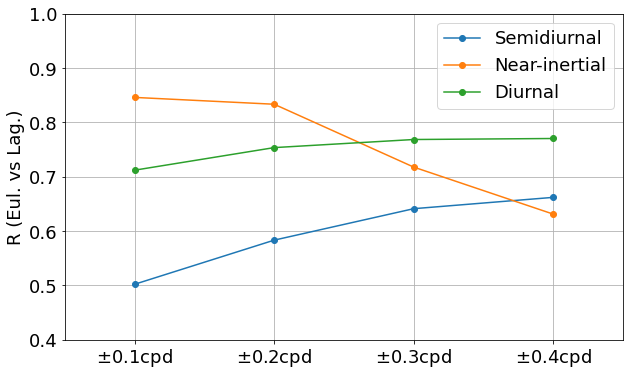

In [29]:
R_SD = [0.50222586, 0.58332799, 0.64119098, 0.66201533]
R_NI = [0.84589033, 0.83333659, 0.71771398, 0.63122448]
R_D =  [0.71205043, 0.7535519 , 0.76845071,0.77031097]

labels = ['Semidiurnal', 'Near-inertial', 'Diurnal']
font_size=18
fig, ax = plt.subplots(figsize=(10,6))
ax = plt.subplot(111)
plt.plot(R_SD, '-o',label=labels[0])
plt.plot(R_NI, '-o',label=labels[1])
plt.plot(R_D, '-o',label=labels[2])
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0., 1., 2., 3.])
ax.set_xticklabels(['$\pm$0.1cpd','$\pm$0.2cpd','$\pm$0.3cpd','$\pm$0.4cpd'])
ax.set_ylim([0.4,1])
ax.grid()
ax.set_ylabel('R (Eul. vs Lag.)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.legend(prop={'size': font_size}); 
ax.set_title('',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Correlation_bandwidth.png')

## Slope

In [11]:
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])

In [12]:
upper_limit = 0.2
slopes = xr.apply_ufunc(linear_trend,
                        ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).mean('lon_bins').sel(frequency_band='semidiurnal_0dot1'), 
                        ds_E.E_Eulerian.mean('lon_bins').sel(frequency_band='semidiurnal_0dot1'),
                        vectorize=True,
                        input_core_dims=[['lat_bins'], ['lat_bins']],# reduce along 'plev'
                        )
slopes

<xarray.DataArray ()>
array(0.80329659)
Coordinates:
    frequency_band  <U17 'semidiurnal_0dot1'

In [13]:
upper_limit = 0.2
slopes = xr.apply_ufunc(linear_trend,
                        ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).mean('lat_bins'), 
                        #ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).mean('lon_bins').sel(frequency_band='semidiurnal_0dot1'), 
                        ds_E.E_Eulerian.mean('lat_bins'),
                        vectorize=True,
                        input_core_dims=[['lon_bins'], ['lon_bins']],# reduce along 'plev'
                        )
slopes

<xarray.DataArray (frequency_band: 15)>
array([1.80869869, 1.92733079, 0.83637779, 1.05601985, 0.91148508,
       0.85193949, 0.80778916, 1.10536571, 0.98717252, 0.90989473,
       0.88322201, 1.02119054, 1.04228259, 1.09776373, 1.17663885])
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'

## Regression Coefficient

In [31]:
upper_limit = 0.2
x = ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit)
y = ds_E.E_Eulerian

In [32]:
regression_coef = (x*y).mean(['lat_bins','lon_bins'])/(x**2).mean(['lat_bins','lon_bins'])
regression_coef

<xarray.DataArray (frequency_band: 15)>
array([1.02973471, 1.04867498, 0.85724639, 0.79959352, 0.7939884 ,
       0.78851032, 0.78322774, 0.71578659, 0.75385383, 0.72782507,
       0.72737307, 1.01156443, 0.99677717, 1.00534982, 1.01195439])
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'

In [33]:
rc_D = [regression_coef.sel(frequency_band='diurnal_0dot1').values,
        regression_coef.sel(frequency_band='diurnal_0dot2').values,
        regression_coef.sel(frequency_band='diurnal_0dot3').values,
        regression_coef.sel(frequency_band='diurnal_0dot4').values]

rc_SD = [regression_coef.sel(frequency_band='semidiurnal_0dot1').values,
         regression_coef.sel(frequency_band='semidiurnal_0dot2').values,
         regression_coef.sel(frequency_band='semidiurnal_0dot3').values,
         regression_coef.sel(frequency_band='semidiurnal_0dot4').values]

In [34]:
regression_coef_NI = (x.where(np.abs(x.lat_bins)>15)*y.where(np.abs(y.lat_bins)>15)).mean(['lat_bins','lon_bins'])/(x**2).where(np.abs(x.lat_bins)>15).mean(['lat_bins','lon_bins'])
regression_coef_NI

<xarray.DataArray (frequency_band: 15)>
array([1.0303881 , 1.05520398, 0.78983619, 0.82806377, 0.79060976,
       0.79118542, 0.78924092, 0.70868987, 0.74021204, 0.71658552,
       0.72236365, 0.95298126, 0.90464902, 0.81291043, 0.80118155])
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'

In [35]:
rc_NI = [regression_coef_NI.sel(frequency_band='inertial_0dot1').values,
         regression_coef_NI.sel(frequency_band='inertial_0dot2').values,
         regression_coef_NI.sel(frequency_band='inertial_0dot3').values,
         regression_coef_NI.sel(frequency_band='inertial_0dot4').values]

Text(0.5, 1.0, '')

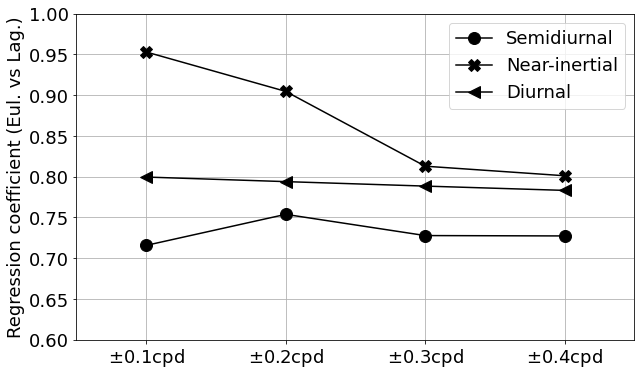

In [37]:
labels = ['Semidiurnal', 'Near-inertial', 'Diurnal']
font_size=18
fig, ax = plt.subplots(figsize=(10,6))
ax = plt.subplot(111)
plt.plot(rc_SD, '-o',label=labels[0],markersize=12,color='black')
plt.plot(rc_NI, '-X',label=labels[1],markersize=12,color='black')
plt.plot(rc_D, '-<',label=labels[2],markersize=12,color='black')
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0., 1., 2., 3.])
ax.set_xticklabels(['$\pm$0.1cpd','$\pm$0.2cpd','$\pm$0.3cpd','$\pm$0.4cpd'])
ax.set_ylim([0.6,1.])
ax.grid()
ax.set_ylabel('Regression coefficient (Eul. vs Lag.)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.legend(prop={'size': font_size}); 
ax.set_title('',fontsize=font_size)

_______
### Regression for global grids

In [39]:
ds_subset = (ds_E.stack(point=['lat_bins', 'lon_bins']))
print(ds_subset)
print('\n data size: %.1f GB' %(ds_subset.nbytes / 1e9))

<xarray.Dataset>
Dimensions:         (frequency_band: 15, point: 42721)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * point           (point) MultiIndex
  - lat_bins        (point) float64 -59.5 -59.5 -59.5 -59.5 ... 58.5 58.5 58.5
  - lon_bins        (point) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
Data variables:
    E_Eulerian      (frequency_band, point) float64 0.1136 0.07362 ... 0.03039
    E_Lagrangian    (frequency_band, point) float64 0.09624 0.07344 ... 0.02225
    E_depth         (point) float64 4.548e+03 4.509e+03 ... 3.745e+03 3.74e+03

 data size: 0.0 GB


In [40]:
ds_subset.load()

<xarray.Dataset>
Dimensions:         (frequency_band: 15, point: 42721)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * point           (point) MultiIndex
  - lat_bins        (point) float64 -59.5 -59.5 -59.5 -59.5 ... 58.5 58.5 58.5
  - lon_bins        (point) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
Data variables:
    E_Eulerian      (frequency_band, point) float64 0.1136 0.07362 ... 0.03039
    E_Lagrangian    (frequency_band, point) float64 0.09624 0.07344 ... 0.02225
    E_depth         (point) float64 4.548e+03 4.509e+03 ... 3.745e+03 3.74e+03

In [41]:
upper_limit = 0.2
slopes = xr.apply_ufunc(linear_trend,
                        ds_subset.E_Eulerian.where(ds_subset.E_Eulerian<upper_limit).fillna(0.), 
                        ds_subset.E_Lagrangian.where(ds_subset.E_Lagrangian<upper_limit).fillna(0.), 
                        vectorize=True,
                        input_core_dims=[['point'], ['point']],# reduce along 'plev'
                        )
slopes

<xarray.DataArray (frequency_band: 15)>
array([0.74319792, 0.72993882, 0.88175106, 0.69887674, 0.8206244 ,
       0.87041008, 0.90332446, 0.45959344, 0.60778791, 0.69472206,
       0.74410749, 0.78564127, 0.80447851, 0.803849  , 0.80359822])
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'

In [42]:
m_D = [slopes.sel(frequency_band='diurnal_0dot1').values,
        slopes.sel(frequency_band='diurnal_0dot2').values,
        slopes.sel(frequency_band='diurnal_0dot3').values,
        slopes.sel(frequency_band='diurnal_0dot4').values]

m_SD = [slopes.sel(frequency_band='semidiurnal_0dot1').values,
         slopes.sel(frequency_band='semidiurnal_0dot2').values,
         slopes.sel(frequency_band='semidiurnal_0dot3').values,
         slopes.sel(frequency_band='semidiurnal_0dot4').values]

m_NI = [slopes.sel(frequency_band='inertial_0dot1').values,
         slopes.sel(frequency_band='inertial_0dot2').values,
         slopes.sel(frequency_band='inertial_0dot3').values,
         slopes.sel(frequency_band='inertial_0dot4').values]

Text(0.5, 1.0, '')

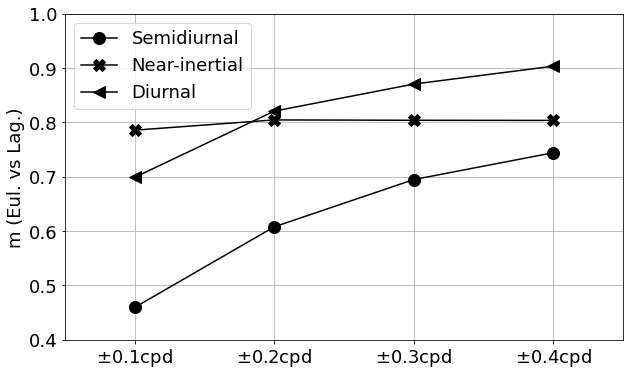

In [44]:
labels = ['Semidiurnal', 'Near-inertial', 'Diurnal']
font_size=18
fig, ax = plt.subplots(figsize=(10,6))
ax = plt.subplot(111)
plt.plot(m_SD, '-o',label=labels[0],markersize=12,color='black')
plt.plot(m_NI, '-X',label=labels[1],markersize=12,color='black')
plt.plot(m_D, '-<',label=labels[2],markersize=12,color='black')
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0., 1., 2., 3.])
ax.set_xticklabels(['$\pm$0.1cpd','$\pm$0.2cpd','$\pm$0.3cpd','$\pm$0.4cpd'])
ax.set_ylim([0.4,1.0])
ax.grid()
ax.set_ylabel('m (Eul. vs Lag.)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.legend(prop={'size': font_size}); 
ax.set_title('',fontsize=font_size)

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Correlation_bandwidth.png')

_________
## An average of ratios

In [21]:
ratio_total = ds_E.E_Eulerian.sel(frequency_band='total')/ds_E.E_Lagrangian.sel(frequency_band='total')
ratio_low = ds_E.E_Eulerian.sel(frequency_band='low')/ds_E.E_Lagrangian.sel(frequency_band='low')

ratio_semi_0dot1 = ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1')/ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<0.2).sel(frequency_band='semidiurnal_0dot1')
ratio_semi_0dot2 = ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot2')/ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<0.2).sel(frequency_band='semidiurnal_0dot2')
ratio_semi_0dot3 = ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot3')/ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<0.2).sel(frequency_band='semidiurnal_0dot3')
ratio_semi_0dot4 = ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot4')/ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<0.2).sel(frequency_band='semidiurnal_0dot4')

ratio_diurnal_0dot1 = ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot1')/ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot1')
ratio_diurnal_0dot2 = ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot2')/ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot2')
ratio_diurnal_0dot3 = ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot3')/ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot3')
ratio_diurnal_0dot4 = ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot4')/ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot4')

ratio_inertial_0dot1 = ds_E.E_Eulerian.sel(frequency_band='inertial_0dot1')/ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot1')
ratio_inertial_0dot2 = ds_E.E_Eulerian.sel(frequency_band='inertial_0dot2')/ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot2')
ratio_inertial_0dot3 = ds_E.E_Eulerian.sel(frequency_band='inertial_0dot3')/ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot3')
ratio_inertial_0dot4 = ds_E.E_Eulerian.sel(frequency_band='inertial_0dot4')/ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot4')

Text(0.5, 0, '')

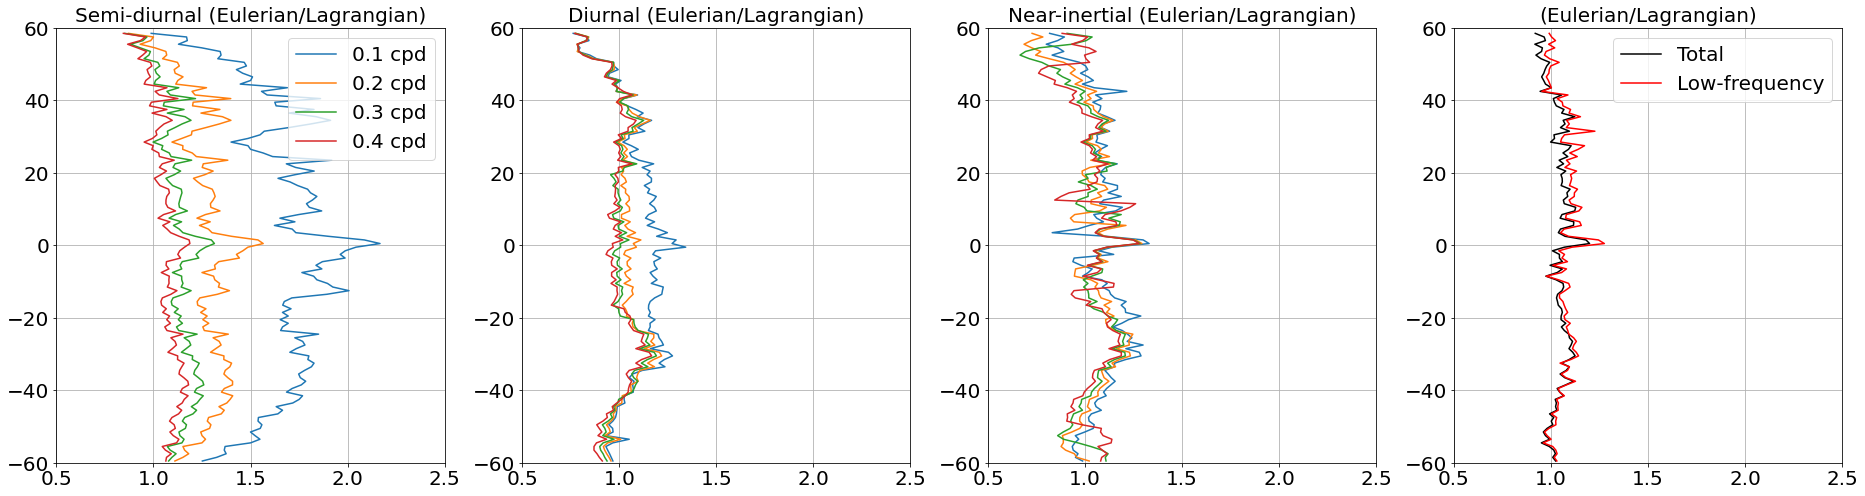

In [22]:
font_size = 20
fig, ax = plt.subplots(figsize=(32,8))

labels = ['0.1 cpd','0.2 cpd','0.3 cpd','0.4 cpd']

ax = plt.subplot(141)
ratio_semi_0dot1.where(np.isinf(ratio_semi_0dot1)==False).where(ratio_semi_0dot1<100).mean('lon_bins').plot(y='lat_bins', label=labels[0])
ratio_semi_0dot2.where(np.isinf(ratio_semi_0dot2)==False).where(ratio_semi_0dot2<100).mean('lon_bins').plot(y='lat_bins', label=labels[1])
ratio_semi_0dot3.where(np.isinf(ratio_semi_0dot3)==False).where(ratio_semi_0dot3<100).mean('lon_bins').plot(y='lat_bins', label=labels[2])
ratio_semi_0dot4.where(np.isinf(ratio_semi_0dot4)==False).where(ratio_semi_0dot4<100).mean('lon_bins').plot(y='lat_bins', label=labels[3])
ax.set_title('Semi-diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.set_xlim(0.5, 2.5)
ax.set_ylim(-60., 60.)
ax.legend(prop={'size': 20}); ax.grid()
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(142)
ratio_diurnal_0dot1.where(np.isinf(ratio_diurnal_0dot1)==False).where(ratio_diurnal_0dot1<100).mean('lon_bins').plot(y='lat_bins')
ratio_diurnal_0dot2.where(np.isinf(ratio_diurnal_0dot2)==False).where(ratio_diurnal_0dot1<100).mean('lon_bins').plot(y='lat_bins')
ratio_diurnal_0dot3.where(np.isinf(ratio_diurnal_0dot3)==False).where(ratio_diurnal_0dot1<100).mean('lon_bins').plot(y='lat_bins')
ratio_diurnal_0dot4.where(np.isinf(ratio_diurnal_0dot4)==False).where(ratio_diurnal_0dot1<100).mean('lon_bins').plot(y='lat_bins')
ax.set_title('Diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.set_xlim(0.5, 2.5)
ax.set_ylim(-60., 60.)
ax.grid()
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(143)
ratio_inertial_0dot1.where(np.isinf(ratio_inertial_0dot1)==False).where(ratio_inertial_0dot1<100).mean('lon_bins').plot(y='lat_bins')
ratio_inertial_0dot2.where(np.isinf(ratio_inertial_0dot2)==False).where(ratio_inertial_0dot1<100).mean('lon_bins').plot(y='lat_bins')
ratio_inertial_0dot3.where(np.isinf(ratio_inertial_0dot3)==False).where(ratio_inertial_0dot1<100).mean('lon_bins').plot(y='lat_bins')
ratio_inertial_0dot4.where(np.isinf(ratio_inertial_0dot4)==False).where(ratio_inertial_0dot1<100).mean('lon_bins').plot(y='lat_bins')
ax.set_title('Near-inertial (Eulerian/Lagrangian)',fontsize=font_size)
ax.set_xlim(0.5, 2.5)
ax.set_ylim(-60., 60.)
ax.grid()
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

labels = ['Total','Low-frequency']

ax = plt.subplot(144)
ratio_total.where(np.isinf(ratio_total)==False).mean('lon_bins').plot(y='lat_bins',color='black', label=labels[0])
ratio_low.where(np.isinf(ratio_low)==False).mean('lon_bins').plot(y='lat_bins',color='red', label=labels[1])
ax.set_title('(Eulerian/Lagrangian)',fontsize=font_size)
ax.set_xlim(0.5, 2.5)
ax.set_ylim(-60., 60.)
ax.legend(prop={'size': 20}); ax.grid()
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

## An average of KE

In [23]:
ratio_total = ds_E.E_Eulerian.sel(frequency_band='total').mean('lon_bins')/ds_E.E_Lagrangian.sel(frequency_band='total').mean('lon_bins')
ratio_low = ds_E.E_Eulerian.sel(frequency_band='low').mean('lon_bins')/ds_E.E_Lagrangian.sel(frequency_band='low').mean('lon_bins')

ratio_semi_0dot1 = ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins')/ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<0.1).sel(frequency_band='semidiurnal_0dot1').mean('lon_bins')
ratio_semi_0dot2 = ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot2').mean('lon_bins')/ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<0.1).sel(frequency_band='semidiurnal_0dot2').mean('lon_bins')
ratio_semi_0dot3 = ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot3').mean('lon_bins')/ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<0.1).sel(frequency_band='semidiurnal_0dot3').mean('lon_bins')
ratio_semi_0dot4 = ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins')/ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<0.1).sel(frequency_band='semidiurnal_0dot4').mean('lon_bins')

ratio_diurnal_0dot1 = ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot1').mean('lon_bins')/ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot1').mean('lon_bins')
ratio_diurnal_0dot2 = ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot2').mean('lon_bins')/ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot2').mean('lon_bins')
ratio_diurnal_0dot3 = ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot3').mean('lon_bins')/ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot3').mean('lon_bins')
ratio_diurnal_0dot4 = ds_E.E_Eulerian.sel(frequency_band='diurnal_0dot4').mean('lon_bins')/ds_E.E_Lagrangian.sel(frequency_band='diurnal_0dot4').mean('lon_bins')

ratio_inertial_0dot1 = ds_E.E_Eulerian.sel(frequency_band='inertial_0dot1').mean('lon_bins')/ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot1').mean('lon_bins')
ratio_inertial_0dot2 = ds_E.E_Eulerian.sel(frequency_band='inertial_0dot2').mean('lon_bins')/ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot2').mean('lon_bins')
ratio_inertial_0dot3 = ds_E.E_Eulerian.sel(frequency_band='inertial_0dot3').mean('lon_bins')/ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot3').mean('lon_bins')
ratio_inertial_0dot4 = ds_E.E_Eulerian.sel(frequency_band='inertial_0dot4').mean('lon_bins')/ds_E.E_Lagrangian.sel(frequency_band='inertial_0dot4').mean('lon_bins')

Text(0.5, 0, '')

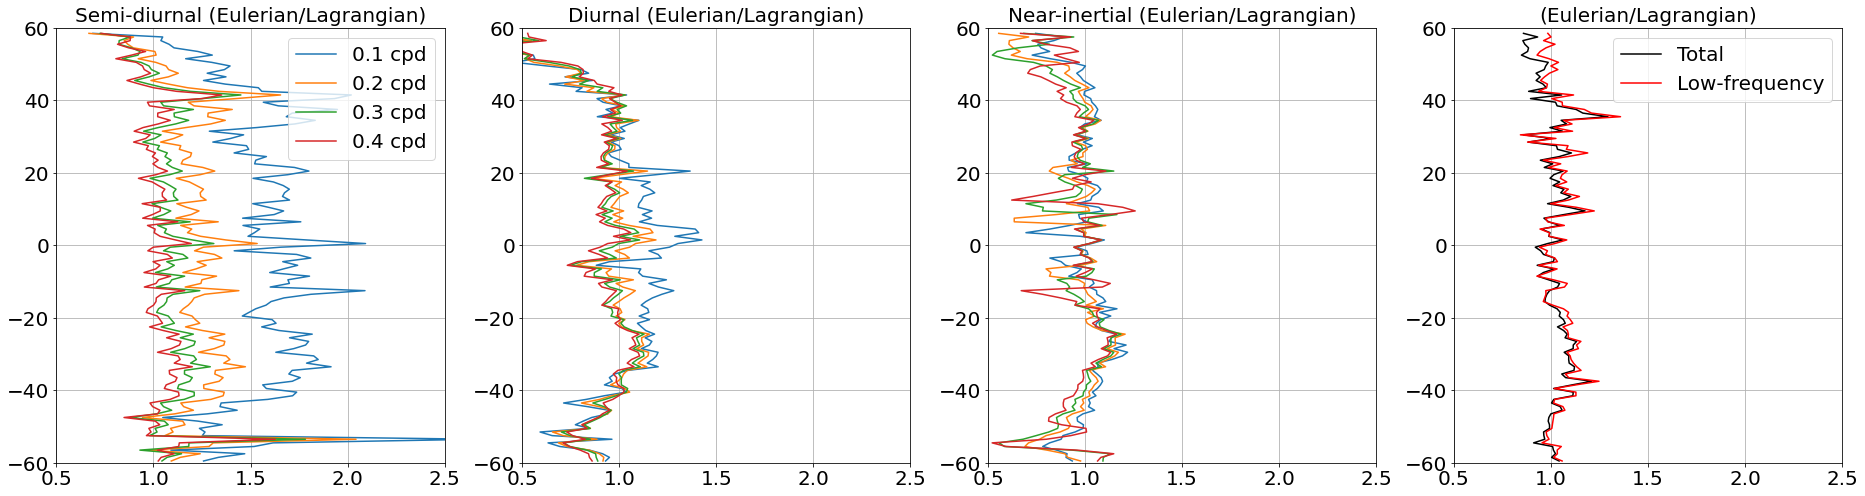

In [24]:
font_size = 20
fig, ax = plt.subplots(figsize=(32,8))

labels = ['0.1 cpd','0.2 cpd','0.3 cpd','0.4 cpd']

ax = plt.subplot(141)
ratio_semi_0dot1.plot(y='lat_bins', label=labels[0])
ratio_semi_0dot2.plot(y='lat_bins', label=labels[1])
ratio_semi_0dot3.plot(y='lat_bins', label=labels[2])
ratio_semi_0dot4.plot(y='lat_bins', label=labels[3])
ax.set_title('Semi-diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.set_xlim(0.5, 2.5)
ax.set_ylim(-60., 60.)
ax.legend(prop={'size': 20}); ax.grid()
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(142)
ratio_diurnal_0dot1.plot(y='lat_bins')
ratio_diurnal_0dot2.plot(y='lat_bins')
ratio_diurnal_0dot3.plot(y='lat_bins')
ratio_diurnal_0dot4.plot(y='lat_bins')
ax.set_title('Diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.set_xlim(0.5, 2.5)
ax.set_ylim(-60., 60.)
ax.grid()
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(143)
ratio_inertial_0dot1.plot(y='lat_bins')
ratio_inertial_0dot2.plot(y='lat_bins')
ratio_inertial_0dot3.plot(y='lat_bins')
ratio_inertial_0dot4.plot(y='lat_bins')
ax.set_title('Near-inertial (Eulerian/Lagrangian)',fontsize=font_size)
ax.set_xlim(0.5, 2.5)
ax.set_ylim(-60., 60.)
ax.grid()
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

labels = ['Total','Low-frequency']

ax = plt.subplot(144)
ratio_total.plot(y='lat_bins',color='black', label=labels[0])
ratio_low.plot(y='lat_bins',color='red', label=labels[1])
ax.set_title('(Eulerian/Lagrangian)',fontsize=font_size)
ax.set_xlim(0.5, 2.5)
ax.set_ylim(-60., 60.)
ax.legend(prop={'size': 20}); ax.grid()
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

## Close cluster

In [47]:
cluster.close()